# CERN AWAKE 2019 GSoC Evaluation Test

### Michael Moore, BSc in Physics with Astronomy
### Dublin City University, Dublin, Ireland

Note that the data file downloaded from CERNBox is assumed to be located in the 'Data/' subdirectory in relation to this notebook.

In [135]:
# Importing all required modules

# Python standard library modules
import datetime
import pytz
import csv

# Third-party modules
import h5py
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# 'Magic' Jupyter code to embed Matplotlib images in the notebook.
%matplotlib inline

In [136]:
# Conveniently define data file
filename = 'Data/1541962108935000000_167_838.h5'

## Part 1: Converting UNIX timestamp on data file to UTC and CERN local times.

In [146]:
# Define UNIX timestamp (in ns) on filename as an integer variable
unix_timestamp = int(filename[5:24])

# UNIX timestamp is generally accepted in seconds, not nanoseconds, so convert by dividing by 10^9
ts_in_seconds = unix_timestamp//1e9

# Create parent datetime object
dt = datetime.datetime.utcfromtimestamp(ts_in_seconds)

# datetime object 'dt' is already in UTC time. To convert to CERN local time, use pytz module to reference the UTC +01:00 timezone:
utc_time = dt
cern_tz = pytz.timezone('Europe/Berlin') # Berlin and Geneva in the same timezone
cern_time = dt.astimezone(cern_tz)

# Display times
print('UTC:', utc_time)
print('CERN:', cern_time)

UTC: 2018-11-11 18:48:28
CERN: 2018-11-11 19:48:28+01:00


## Part 2: Exploring the data and recording metadata

In [145]:
# Read in data file
entire_directory = h5py.File(filename,'r')

# Display contents of file in directory-tree-like format for clarity (top 2 levels)
for directory in entire_directory:
    print('\n',directory)
    for sub in entire_directory[directory]:
        print('\t',sub)


 AwakeEventData
	 AIRTR01
	 AIRTR02
	 AWAKEInjPhaseShifter
	 BLMITT41
	 BOVWA.01TCC4.AWAKECAM01
	 BOVWA.01TCV4.CAM8
	 BOVWA.02TCC4.AWAKECAM02
	 BOVWA.02TSG40.CAM7
	 BOVWA.03TT41.CAM3
	 BOVWA.04TCC4.AWAKECAM04
	 BOVWA.04TT41.CAM4
	 BOVWA.05TT41.CAM5
	 BOVWA.06TCC4.AWAKECAM06
	 BOVWA.07TCC4.AWAKECAM07
	 BOVWA.11TCC4.AWAKECAM11
	 BPM.AWAKE.TT41
	 BTV.TT41.412354_FILTER
	 BTV.TT41.412426_FWHEEL
	 BTV.TT41.412426_MASK_H
	 BTV.TT41.412426_MASK_V
	 BTV.TT41.412442_FWHEEL
	 BTV.TT41.412442_MASK_H
	 BTV.TT41.412442_MASK_V
	 EMETER02
	 EMETER03
	 EMETER04
	 EMETER05
	 FWHEEL01
	 GD_BPM.AWAKE.TRIUMF
	 LSSE2
	 LSSP2
	 MPP-TSG41-MIRROR1-H
	 MPP-TSG41-MIRROR1-V
	 MPP-TSG41-WHEEL1-BI
	 MPP-VACTRANS-CTR
	 MPP-VACTRANS-OTR
	 MPPAWAKE-STANDA-08.AXIS01
	 MPPAWAKE-STANDA-08.AXIS02
	 MPPAWAKE-STANDA-08.AXIS03
	 MPPAWAKE-STANDA-08.AXIS04
	 MPPAWAKE-STANDA-08.AXIS09
	 MPPAWAKE-STANDA-08.AXIS10
	 MPPAWAKE-STANDA-08.AXIS11
	 MPPAWAKE-STANDA-08.AXIS12
	 MPPAWAKE-STANDA-12.AXIS01
	 MPPAWAKE-STANDA-12.AXIS02
	 M

In [139]:
def dataset_finder(h5_file,dataset_list,address_str):
    '''
    Accepts h5py File or Group. Returns a list of dataset
    paths within the h5_file variable
    '''
    for entry in h5_file:
        if entry != '__DATA_TYPES__': # Issue with data in this Group
            if type(h5_file[entry]) in (h5py._hl.group.Group,h5py._hl.files.File):
                dataset_list = dataset_finder(h5_file[entry],dataset_list,address_str + '/' + entry)

            else:
                dataset_list.append(address_str + '/' + entry)

    return dataset_list

In [144]:
# Define empty list to feed into dataset_finder. Will then
# contain paths to all datasets in the data file
datasets = []
datasets = dataset_finder(entire_directory,datasets,'')

# Empty lists for use in capturing dataset metadata
ds_shapes = []
ds_sizes = []
ds_dtypes = []

for ds in datasets:
    ds_shapes.append(entire_directory[ds].shape) # Record dataset shape
    ds_sizes.append(entire_directory[ds].size) # Record dataset size
    
    # Problem with TypeBitfieldID datatype - not NumPy compatible
    try:
        # Record dtype if not an issue
        ds_dtypes.append(str(entire_directory[ds].dtype)) 
        
    except TypeError:
        # If an error is raised, manually record 'TypeBitfieldID'
        ds_dtypes.append('TypeBitfieldID')

# Empty list to contain all data for output to CSV file
all_info = []

# Iterate through all lists created above and combine info about:
# 1. Dataset path
# 2. Dataset shape
# 3. Dataset size
# 4. Dataset data type
for name,shape,size,dtype in zip(datasets,ds_shapes,ds_sizes,ds_dtypes):
    all_info.append({'Dataset':name,'Shape':shape,'Size':size,'Data Type':dtype})
    
# Write this data to a file, with the 'fields' list defining
# column headings
with open('Datasets.csv','w+') as file:
    fields = ['Dataset','Shape','Size','Data Type']
    writer = csv.DictWriter(file,fieldnames=fields)
    writer.writeheader()
    writer.writerows(all_info)
    
file.close()

## Part 3: Generating and saving event image

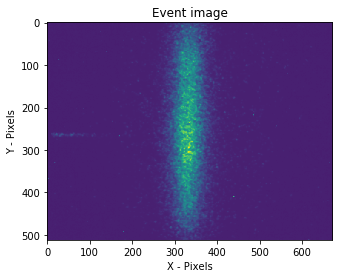

In [143]:
# Creating NumPy array from data stored in data file
image_array = np.array(entire_directory['AwakeEventData/XMPP-STREAK/StreakImage/streakImageData'])

# Extracting image height and width data from data file
image_height = np.array(entire_directory['AwakeEventData/XMPP-STREAK/StreakImage/streakImageHeight'])[0]
image_width = np.array(entire_directory['AwakeEventData/XMPP-STREAK/StreakImage/streakImageWidth'])[0]

# Reshape array using numpy.reshape and filter using scipy.signal.medfilt
raw_image = np.reshape(image_array,(image_height,image_width))
filtered_image = sig.medfilt(raw_image,[3,3])

# Plot image
plt.figure()
plt.imshow(filtered_image)
plt.title('Event image')
plt.xlabel('X - Pixels')
plt.ylabel('Y - Pixels')

# Save image
plt.savefig('MMoore_Event_Image.png')